### Notebook to plot BOWTIE sounding data power spectra.

James Ruppert  
jruppert@ou.edu  
8/19/24

### Main settings

In [1]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib import rc, colors, ticker
import matplotlib.dates as mdates
from thermo_functions import *
import subprocess, cmocean
import xarray as xr
import pandas as pd
import seaborn as sns
import scipy.stats as stats
from time_series_diag import *
from bowtie_read_data import *

### Main read loop

In [2]:
# Soundings
snd_asc, snd_files, times_asc = read_bowtie_soundings(search_string = 'ascen')
# soundings, snd_files, times_snd = read_bowtie_soundings(search_string = 'descen')
hght = snd_asc['hght']

### Compute diagnostics

In [3]:
# Vertical mass-weighted integral
#   inputs:
#       tmpk:   temperature [K]
#       mr:     water vapor mixing ratio [kg/kg]
#       p:      pressure [Pa]
#       hght:   height [m]
#   options:
#       minpres: set this to minimum pressure to integrate over [Pa]
def vert_integral(invar, tmpk, mr, p, hght, minpres=0):
    rho = density_moist(tmpk, mr, p) # kg/m3
    dz = hght[1]-hght[0] # m
    var_int = np.nansum(invar*rho, axis=1, where=(p > minpres))*dz
    var_int[ np.where(var_int == 0) ] = np.nan
    return var_int

In [4]:
# Constants
cp=1004.  # J/K/kg
cpl=4186. # J/k/kg
cpv=1885. # J/K/kg
lv0=2.5e6 # J/kg
g = 9.81 # m/s2
# Latent heat of vaporization
lv = lv0 - (cpl-cpv)*(snd_asc['tmpk']-273.15)

minpres=50e2 # Upper pressure bound for vertical integrals [Pa]

# MSE
dse = cp*snd_asc['tmpk'] + g*hght[np.newaxis,:]
lvq= lv*snd_asc['mr']
mse = dse + lvq

# Static stability
theta = theta_dry(snd_asc['tmpk'], snd_asc['p'])
def smooth_theta(invar, nz_smooth=10):
    invar_pd = pd.DataFrame(invar)
    invar_pd = invar_pd.rolling(axis=1,window=nz_smooth, center=True, closed='both', min_periods=3).mean()
    return np.squeeze(np.array(invar_pd))
for ido in range(3):
    theta = smooth_theta(theta, nz_smooth=10)
dthdz = np.gradient(theta, hght, axis=1) # K/m
# for ido in range(10):
dthdz = smooth_theta(dthdz, nz_smooth=20)

tmpk_ddz = np.copy(snd_asc['tmpk'])
for ido in range(3):
    tmpk_ddz = smooth_theta(tmpk_ddz, nz_smooth=10)
dtdz = np.gradient(tmpk_ddz, hght, axis=1) # K/m
dtdz = smooth_theta(dtdz, nz_smooth=20)

# CWV/PW
# 1/g int(q)dp = s2/m * kg/m/s2 --> kg/m2 --> x1/rho_l --> 10^-3 kg/m2*m3/kg --> 10^-3m = mm
# int<q*rho>dz = kg/m3*m = kg/m2 = mm
cwv = vert_integral(snd_asc['mr'], snd_asc['tmpk'], snd_asc['mr'], snd_asc['p'],
                    hght, minpres=0) # mm or kg/m2

/var/folders/9x/209ltwrn2b359nrrh4638hv40000gp/T/ipykernel_77214/1126967735.py:21: FutureWarning: Support for axis=1 in DataFrame.rolling is deprecated and will be removed in a future version. Use obj.T.rolling(...) instead
  invar_pd = invar_pd.rolling(axis=1,window=nz_smooth, center=True, closed='both', min_periods=3).mean()
/var/folders/9x/209ltwrn2b359nrrh4638hv40000gp/T/ipykernel_77214/1126967735.py:21: FutureWarning: Support for axis=1 in DataFrame.rolling is deprecated and will be removed in a future version. Use obj.T.rolling(...) instead
  invar_pd = invar_pd.rolling(axis=1,window=nz_smooth, center=True, closed='both', min_periods=3).mean()
/var/folders/9x/209ltwrn2b359nrrh4638hv40000gp/T/ipykernel_77214/1126967735.py:21: FutureWarning: Support for axis=1 in DataFrame.rolling is deprecated and will be removed in a future version. Use obj.T.rolling(...) instead
  invar_pd = invar_pd.rolling(axis=1,window=nz_smooth, center=True, closed='both', min_periods=3).mean()
/var/folders/

### Compute power spectra

In [5]:
t_ind=np.where(times_asc >= times_asc[13])[0]

z_vars_tag = ['p','tmpk','rh','mr','u','v','wdir']
ntag = len(z_vars_tag)

pspec = compute_power_spec(snd_asc['v'][t_ind,500], time_step=1/8)
freqs = pspec['freqs']
nf=freqs.size
nz=snd_asc['v'].shape[1]

pspec_all=[]
for itag in z_vars_tag:
    dims=(nf,nz)
    pspec_z = np.zeros(dims)
    # rspec_z = np.zeros(dims)
    # spec95_z = np.zeros(dims)
    # spec99_z = np.zeros(dims)
    for iz in range(nz):
        if np.count_nonzero(~np.isnan(snd_asc[itag][t_ind,iz])) < 10:
            continue
        pspec = compute_power_spec(snd_asc[itag][t_ind,iz], time_step=1/8)
        pspec_z[:,iz] = pspec['ps']
        # rspec_z[:,iz] = pspec['rspec']
        # spec95_z[:,iz] = pspec['spec95']
        # spec99_z[:,iz] = pspec['spec99']
    pspec_all.append(pspec_z)

---
### Plotting routines

#### Plot functions

In [6]:
font = {'family' : 'sans-serif',
        'weight' : 'normal',
        'size'   : 12}

rc('font', **font)

# sns.set_theme(style="darkgrid", rc={'xtick.bottom': True, 'ytick.left': True,})

In [7]:
def plot_time_height_pspec(figdata, top=18):

    fig_x = 9
    fig_y = 3.5
    fig, ax = plt.subplots(figsize=(fig_x,fig_y), layout="constrained",) # row, column

    ax.set_title(figdata['fig_title'])

    ax.set_ylabel('Height [km]')
    ax.set_ylim(0,top)
    ax.set_xlim((0,3))
    ax.set_xlabel('$f$ [cycles/day]')

    ax.grid(True, axis='x', color='0.55', linewidth=0.5, zorder=4)
    ax.grid(True, axis='y', color='0.55', linewidth=0.5, zorder=4)#, which='both')

    # Plot variable
    xdim=freqs
    pltvar = figdata['pltvar']

    norm=colors.LogNorm(vmin=1e-3, vmax=1e1)#np.min(figdata['clevels']), np.max(figdata['clevels']))
    # norm=colors.Normalize(vmin=0, vmax=0.5)#np.min(figdata['clevels']), np.max(figdata['clevels']))
    # im = ax.pcolormesh(np.repeat(xdim[:,np.newaxis],len(hght),axis=1),
    #                    np.repeat(hght[np.newaxis,:]*1e-3,len(xdim),axis=0),
    #                    pltvar, cmap=cmocean.cm.rain, shading='gouraud', norm=norm)#figdata['norm'])
    # im = ax.pcolormesh(xdim, hght*1e-3, pltvar, cmap=cmocean.cm.rain, shading='gouraud', norm=norm)#figdata['norm'])
    im = ax.contourf(xdim, hght*1e-3, pltvar.transpose(), np.logspace(-3,1,num=30),#np.arange(0,.55,.05),
                    extend='max', cmap=cmocean.cm.rain, zorder=1, norm=norm)
    # fig.colorbar(im, ax=ax, label='Normalized Power', ticks=ticker.AutoLocator())#, shrink=0.6)
    fig.colorbar(im, ax=ax, label='Normalized Power', ticks=ticker.LogLocator())#, norm=norm)#, shrink=0.6)

    # Line contours
    # im = ax.contour(xdim, hght*1e-3, pltvar.transpose(), figdata['clevels_line'],
    #                 colors='black',linewidths=0.6, zorder=2)

    plt.show()
    plt.close()
    return

/var/folders/9x/209ltwrn2b359nrrh4638hv40000gp/T/ipykernel_77214/1405205352.py:27: UserWarning: Log scale: values of z <= 0 have been masked
  im = ax.contourf(xdim, hght*1e-3, pltvar.transpose(), np.logspace(-3,1,num=30),#np.arange(0,.55,.05),


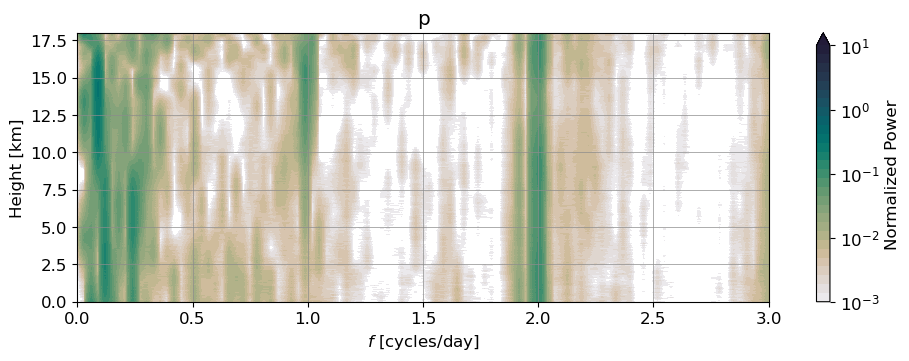

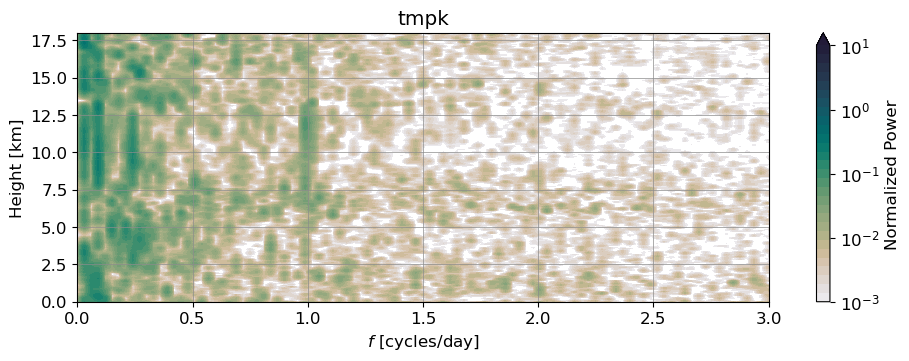

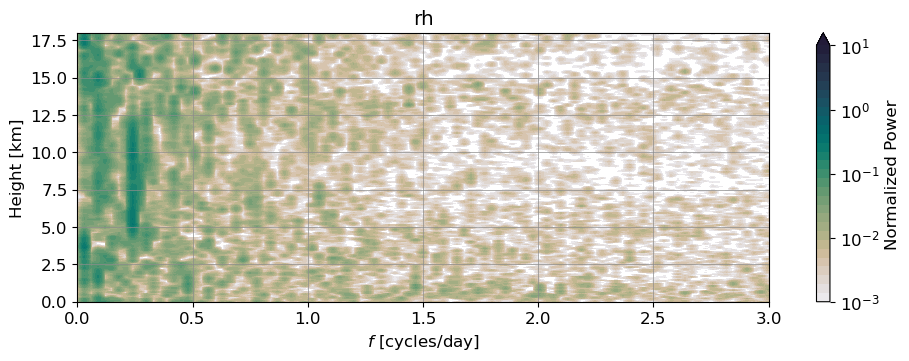

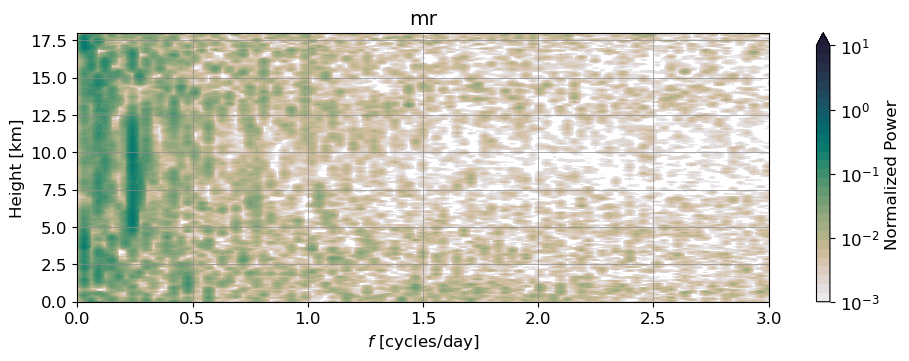

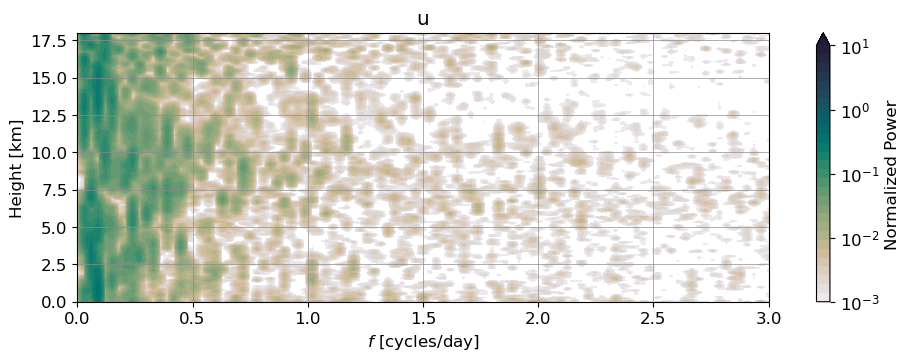

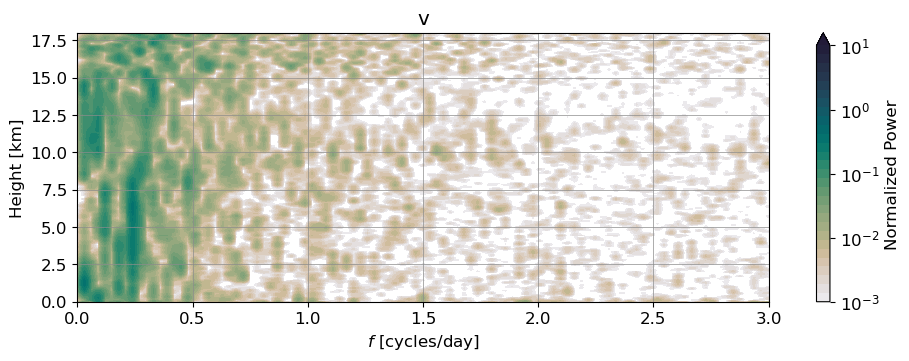

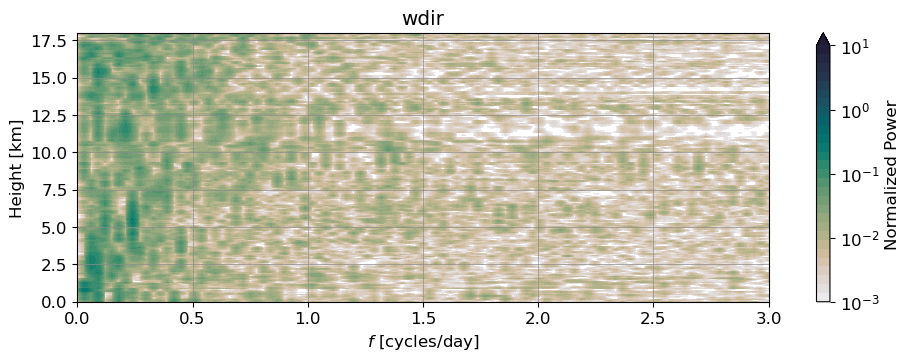

In [8]:
for itag in range(ntag):

    figdata = {
        'pltvar': pspec_all[itag],
        'fig_title': z_vars_tag[itag],
            }

    plot_time_height_pspec(figdata, top=18)